In [2]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically

# load general packages
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

# load modules related to this exercise
import tools 
from model_dc_multidim import model_dc_multidim
import time

In [3]:
t0 = time.time()  # set the starting time
model = model_dc_multidim()
model.setup()
model.create_grids()
model.solve()
t1 = time.time() # set the ending time
print(f'time: {t1-t0:.8} seconds') # print the total time

[0.81181941 0.8681643  0.92028125 0.97219003 1.02603719 1.08391117
 1.14897966 1.22872538]
8
7
6
5
4
3
2
1
0
time: 477.79211 seconds


In [5]:
def simulate (model):
    par = model.par
    sol = model.sol
    sim = model.sim

    # Initialize
    shape = (par.simT, par.simN)
    sim.m = np.nan +np.zeros(shape)
    sim.c = np.nan +np.zeros(shape)
    sim.a = np.nan +np.zeros(shape)
    sim.h = np.nan +np.zeros(shape)
    
    sim.Th = np.nan +np.zeros(shape)
    sim.Tw = np.nan +np.zeros(shape)

    sim.y = np.nan +np.zeros(shape)

    par.Nshocks = par.xi.size * par.Na
    # Shocks
    shock = np.random.choice(par.xi, (par.T,par.simN),replace=True,p=par.xi_w) #draw values between 0 and Nshocks-1, with probability w
    
    sim.xi = shock

    #check it has a mean of 1
    assert (abs(1-np.mean(sim.xi)) < 1e-4), 'The mean is not 1 in the simulation of xi'

    # Initial values
    sim.m[0,:] = par.sim_mini
    sim.h[0,:] = 1 

    # Simulation 
    for t in range(par.simT):
        V = np.zeros( (model.par.NT, model.par.simN) )
        C = np.zeros( (model.par.NT, model.par.simN) )
        for i, T_i in enumerate(model.par.T_boundles): # possible hour choices
            C[i, :] =tools.interp_2d_vec(par.grid_m, par.grid_h, sol.c[t, i], sim.m[t, :], sim.h[t, :])
            V[i, :] = tools.interp_2d_vec(par.grid_m , par.grid_h, sol.v[t, i ], sim.m[t, :], sim.h[t, :]) # value for every choice
        
        h_i = V.argmax(0) # index of best choice
        sim.Th[t, :] = model.par.T_boundles[h_i][:, 0]
        sim.Tw[t, :] = model.par.T_boundles[h_i][:, 1]
        Cs = C[:, h_i][0, :] # magic to get all the best choices
        sim.c[t, :] = Cs
        sim.a[t,:] = sim.m[t,:] - sim.c[t,:]
        if t< par.simT-1:
            sim.h[t+1,:] = (1 - par.gamma + par.kappa * (sim.Th[t, :]) / (1050)) * sim.h[t,:]
            wage_plus = np.exp(sim.h[t+1,:]) * par.Rh * sim.xi[t, :] # next period wage w. health effect on wage 
            m_plus = par.R * sim.a[t, :] + wage_plus * (sim.Tw[t, :]) / (3000)
            sim.m[t+1,:] = par.R * sim.a[t, :] + wage_plus * (sim.Tw[t, :]) / (3000)
simulate(model)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


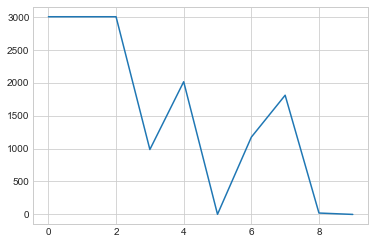

In [18]:
hs = []
tim = [range(10)]
for i in range(10):
    h = model.sim.Tw[i, :]
    h = np.average(h)
    hs.append(h)
plt.plot(hs)

[10, 9, 8, 7, 6]


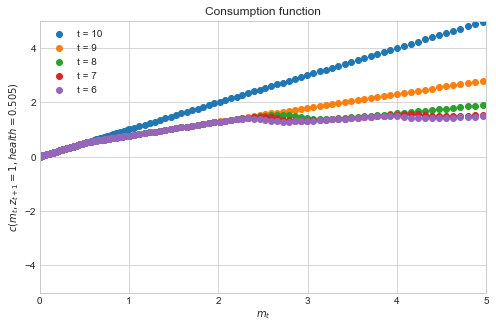

In [13]:
# Figure
def figure_multi_dim(par,sol,T,i_h):
    p = par.grid_h[i_h]

    ts = [par.T, par.T-1, par.T-2, par.T-3, par.T-4]
    print(ts)
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1)
    
    for i in ts:
        ax.scatter(par.grid_m,sol.c[i-1,T,:,i_h], label=f't = {i}')
    ax.set_xlabel(f"$m_t$")
    ax.set_ylabel(f"$c(m_t,z_{{t+1}} = {T}, health = {p:.3})$")
    ax.set_xlim([0, 5])
    ax.set_ylim([-5,5])
    ax.set_title(f'Consumption function')
    plt.legend()
    plt.show()

figure_multi_dim(model.par,model.sol, 1, 50)
#figure_multi_dim(model.par,model.sol, 10, 50)
#figure_multi_dim(model.par,model.sol, 30, 50)